Jupyter Notebook은 개인 PC에서 환경 설정이 어려운 경우
Colab과 google drive를 활용하여 실험할 수 있도록 작성되었습니다.
main.py와 경로와 활용되는 라이브러리만 차이가 있을 뿐입니다.

In [1]:
!pip install soundfile librosa

개인 구글 드라이브 마운트
저의 경우에는 google drive 홈에서 "Colab Notebooks"라는 폴더에 github에서 받은 코드와 음원이 존재하여, 아래와 같이 설정하였습니다.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
colab_basedir = '/content/drive/My Drive/Colab Notebooks'

Mounted at /content/drive


In [3]:
import numpy as np
import soundfile as sf
import librosa
import librosa.display
import os, sys, argparse
import scipy
import scipy.io.wavfile
from scipy import signal
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = FutureWarning)

음원의 샘플번호와 filter 종류를 기입

In [4]:
# MODIFY THE SAMPLE AND FILTER
sample_idx = 1 # 1 ~ 5
filter_mode = 'lowpass' # lowpass, highpass, or bandpass

In [5]:
# DO NOT MODIFY PARAMETER!
fc = [500, 5000]
fs = 16000
len_filter = 512
if filter_mode.lower() == 'lowpass':
    coeff_b = signal.firwin(len_filter, [1, fc[0]], nyq = fs//2, pass_zero = False)
elif filter_mode.lower() == 'highpass':
    coeff_b = signal.firwin(len_filter, [fc[1], fs//2 - 1], nyq = fs//2, pass_zero = False)
elif filter_mode.lower() == 'bandpass':
    coeff_b = signal.firwin(len_filter, [fc[0], fc[1]], nyq = fs//2, pass_zero = False)
else:
    raise ValueError('Select \'lowpass\', \'highpass\', or \'bandpass\' instead of \'{}\''.format(filter_mode))

In [6]:
# sig, _ = librosa.load(os.path.join('samples', 'mixed_{}.wav'.format(sample_idx)), mono = True, sr = fs) # source audio file
sig, _ = librosa.load(os.path.join(colab_basedir,'samples', 'mixed_{}.wav'.format(sample_idx)), mono = True, sr = fs) # source audio file
rec_name = 'mixed_{}_{}.wav'.format(sample_idx, filter_mode.lower())

if not os.path.exists(os.path.join(colab_basedir, 'recorded', rec_name)):
    raise ValueError("Can't find {} in {}".format(rec_name, 'recorded'))

dis, _ = librosa.load(os.path.join(colab_basedir,'recorded', rec_name), mono = True, sr = fs) # record audio file
ref = signal.lfilter(coeff_b, 1, sig)

In [7]:
# DO NOT MODIFY BELOW CODE!
# Modify recorded audio file
if len(dis) < len(ref):
    print('[Warn] Not all of the played files were recorded (back parts).')
    dis = np.pad(dis, (0, len(ref) - len(dis)), 'constant')
# Remove silent
for th in np.array([80, 70, 60, 50, 40, 30]):
    dis_, on_off = librosa.effects.trim(dis, top_db = th)
    if (on_off[1] - on_off[0] > len(sig) * 0.65) and (on_off[1] - on_off[0] <= len(sig)):
        break
# Synchronize two signal
# corr = fftconvolve(sig, dis_[::-1], mode = 'same')
# delay = 2 * (len(corr)//2 - np.argmax(corr))
DELAY_CONTEXT_SIZE = 24_000
sig_rms = librosa.feature.rms(y = ref)
dis_rms = librosa.feature.rms(y = dis_)
norm_sig = sig
norm_dis = dis_ * (np.mean(sig_rms) / np.mean(dis_rms))
corr = np.correlate(norm_sig[:DELAY_CONTEXT_SIZE], norm_dis[:DELAY_CONTEXT_SIZE], mode = 'full')
delay = np.argmax(corr) - (len(sig[:DELAY_CONTEXT_SIZE]) - 1)
if delay < 0:
    print('[Warn] Not all of the played files were recorded (front parts).')
    dis_ = np.concatenate((np.zeros(-delay), dis_))

delay = np.max([delay, 0])
print('[Info] {:.2f} second delay in audio file'.format(delay / fs))
dis_rs = np.zeros(len(ref))
if len(dis_) + delay > len(ref):
    dis_rs[delay:delay + len(dis_[:len(ref) - delay])] = dis_[:len(ref) - delay]
    print('[Info] last {:.2f} second recored signal reducted'.format((len(dis_) - len(dis_[:len(ref) - delay])) / fs))
else:
    dis_rs[delay:delay + len(dis_)] = dis_

[Info]0.00 second delay in audio file
[Warn] last 0.00 second recored signal reducted due to recording environment


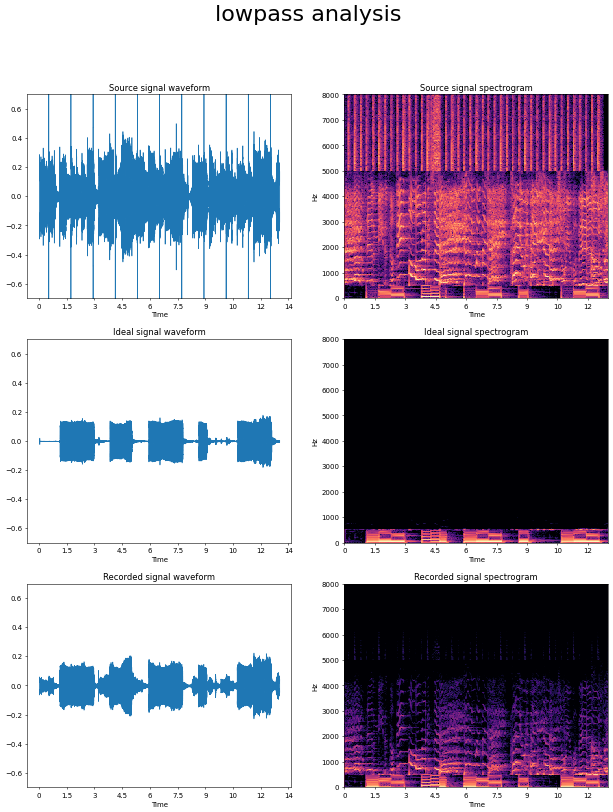

In [8]:
fig = plt.figure(dpi = 50, figsize = (15, 18), facecolor = 'white')
fig.suptitle('{} analysis'.format(filter_mode), fontsize = 32)
ax = plt.subplot(321)
ax.set(title = 'Source signal waveform')
librosa.display.waveshow(sig, sr = fs, max_points = fs//2, x_axis = 'time')
plt.ylim([-0.7, 0.7])
ax = plt.subplot(322)
ax.set(title = 'Source signal spectrogram')
SIG = librosa.amplitude_to_db(np.abs(librosa.stft(sig)), ref = np.max)
librosa.display.specshow(SIG, y_axis = 'linear', x_axis = 'time', sr = fs)
ax = plt.subplot(323)
ax.set(title = 'Ideal signal waveform')
librosa.display.waveshow(ref, sr = fs, max_points = fs//2, x_axis = 'time')
plt.ylim([-0.7, 0.7])
ax = plt.subplot(324)
ax.set(title = 'Ideal signal spectrogram')
REF = librosa.amplitude_to_db(np.abs(librosa.stft(ref)), ref = np.max)
librosa.display.specshow(REF, y_axis = 'linear', x_axis = 'time', sr = fs)
ax = plt.subplot(325)
ax.set(title = 'Recorded signal waveform')
librosa.display.waveshow(dis_rs, sr = fs, max_points = fs//2, x_axis = 'time')
plt.ylim([-0.7, 0.7])
ax = plt.subplot(326)
ax.set(title = 'Recorded signal spectrogram')
DIS = librosa.amplitude_to_db(np.abs(librosa.stft(dis_rs)), ref = np.max)
librosa.display.specshow(DIS, y_axis = 'linear', x_axis = 'time', sr = fs)


In [9]:
# DO NOT MODIFY BELOW CODE
# Objective measure
def freq_segSISNR(ref, dis, fs = 16_000, n_fft = 4096, win_length = 4096, hop_length = 1024):
    eps = 1e-16
    MIN_SNR, MAX_SNR= -10, 35 # minimum/maximum SNR in dB
    S = librosa.stft(ref, n_fft = n_fft, hop_length = hop_length, win_length = win_length)
    S = np.abs(S).T
    X = librosa.stft(dis, n_fft = n_fft, hop_length = hop_length, win_length = win_length)
    X = np.abs(X).T

    dot_product = np.multiply(S, X).sum(-1).reshape(-1, 1)
    squares = np.multiply(S, S).sum(-1).reshape(-1, 1)
    s_target = S * dot_product / (squares + eps)

    e_noise = X - s_target
    s_target_squared = np.multiply(s_target, s_target).sum(-1)
    e_noise_squared = np.multiply(e_noise, e_noise).sum(-1)

    segsnr = 10. * np.log10(s_target_squared / (e_noise_squared + eps) + eps)
    segsnr[segsnr < MIN_SNR] = MIN_SNR
    segsnr[segsnr > MAX_SNR] = MAX_SNR
    segsnr = segsnr[:-1]
    return np.mean(segsnr), segsnr

segsisnr, _ = freq_segSISNR(ref * 1., dis_rs * 1.)
print('[Info]Segmental scale-invariant signal-to-noise(seg SI-SNR) score is {:.4f}'.format(segsisnr))

[Info]Segmental scale-invariant signal-to-noise(seg SI-SNR) score is 8.0170


In [10]:
# Save figure
if not os.path.exists(os.path.join(colab_basedir, 'exps')):
    os.mkdir(os.path.join(colab_basedir, 'exps'))
fig.savefig(os.path.join(colab_basedir, 'exps', 'mixed_{}_{}.png').format(sample_idx, filter_mode), transparent = True)
ax.clear()
# Save reference signal
if not os.path.exists(os.path.join(colab_basedir, 'references')):
    os.mkdir(os.path.join(colab_basedir, 'references'))
scipy.io.wavfile.write(os.path.join(colab_basedir, 'references', 'mixed_{}_{}.wav'.format(sample_idx, filter_mode)), fs, (np.iinfo(np.int16).max * ref.T).astype(np.int16))